# Data Mining Project - Week 1 - Exploration of Data Set

## Data Mining Specialization - Coursera / University of Illinois at Urbana-Champaign

* Author: Michael Onishi
* Date: November, 2019

### Description
The goal of this task is to explore the Yelp data set to get a sense about what the data look like and their characteristics.


### Dataset setup and exploratory analysis

In [0]:
! wget https://d396qusza40orc.cloudfront.net/dataminingcapstone/YelpDataset/yelp_dataset.tar.gz
! tar xzf yelp_dataset.tar.gz

--2019-11-08 15:51:09--  https://d396qusza40orc.cloudfront.net/dataminingcapstone/YelpDataset/yelp_dataset.tar.gz
Resolving d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)... 54.230.82.42, 54.230.82.137, 54.230.82.176, ...
Connecting to d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)|54.230.82.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443445047 (423M) [application/x-gzip]
Saving to: ‘yelp_dataset.tar.gz’

yelp_dataset.tar.gz 100%[===================>] 422.90M  50.3MB/s    in 22s     

2019-11-08 15:51:31 (19.6 MB/s) - ‘yelp_dataset.tar.gz’ saved [443445047/443445047]



In [0]:
! pip install pyldavis unidecode wordcloud -q

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 245kB 44.4MB/s 


In [0]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import re
from joblib import dump, load
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# Seaborn for plotting and styling
import seaborn as sns
sns.set(style="whitegrid")

pyLDAvis.enable_notebook()

In [0]:
def plot_value_counts(s, title, x_label, y_label, rotation = 0):
  plt.figure(figsize=(12,5))
  sns.barplot(s.index, s.values, alpha = 0.8)
  plt.title(title)
  plt.ylabel(y_label)
  plt.xlabel(x_label)
  plt.xticks(rotation = rotation)

In [0]:
path2files="yelp_dataset_challenge_academic_dataset/"
path2business=path2files+"yelp_academic_dataset_business.json"
path2reviews=path2files+"yelp_academic_dataset_review.json"

df_bus = pd.read_json(path2business, lines=True).set_index('business_id')
df_reviews = pd.read_json(path2reviews, lines = True).set_index('review_id')

In [0]:
print(len(df_bus))
df_bus.head()

42153


,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
business_id,,,,,,,,,,,,,,
vcNAWiLM4dR7D2nwwJ7nCA,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{'Tuesday': {'close': '17:00', 'open': '08:00'...",True,"[Doctors, Health & Medical]",Phoenix,7,"Eric Goldberg, MD",[],-111.983758,AZ,3.5,33.499313,{'By Appointment Only': True},business
JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[Restaurants],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
uGykseHzyS5xAMWoN6YUqA,"505 W North St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '06:00'}...",True,"[American (Traditional), Restaurants]",De Forest,16,Deforest Family Restaurant,[],-89.353437,WI,4.0,43.252267,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
LRKJF43s9-3jG9Lgx4zODg,"4910 County Rd V\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '10:30'}...",True,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,7,Culver's,[],-89.374983,WI,4.5,43.251045,"{'Take-out': True, 'Wi-Fi': 'free', 'Takes Res...",business
RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}...",True,"[Chinese, Restaurants]",De Forest,3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor S...",business


Filtering only Restaurants

In [0]:
df_bus = df_bus[df_bus.categories.apply(lambda x : 'Restaurants' in x)]

In [0]:
len(df_bus)

14303

In [0]:
df_bus.categories.apply(lambda x : x.remove('Restaurants'))

business_id
JwUE5GmEO-sH1FuwJgKBlQ    None
uGykseHzyS5xAMWoN6YUqA    None
LRKJF43s9-3jG9Lgx4zODg    None
RgDg-k9S5YD_BaxMckifkg    None
rdAdANPNOcvUtoFgcaY9KA    None
                          ... 
ZpB2O-WAbbRHdP0V8GrwXA    None
OEUIE8VBa1BbBfr5EPcTOA    None
yZXEELxi8KMwzXCHP345GQ    None
uUsfpN81JCMKyH6c0D0bTg    None
BMjggIgOghBMEXPo8q7q3w    None
Name: categories, Length: 14303, dtype: object

In [0]:
category_count = df_bus.categories.apply(pd.Series).stack().value_counts()

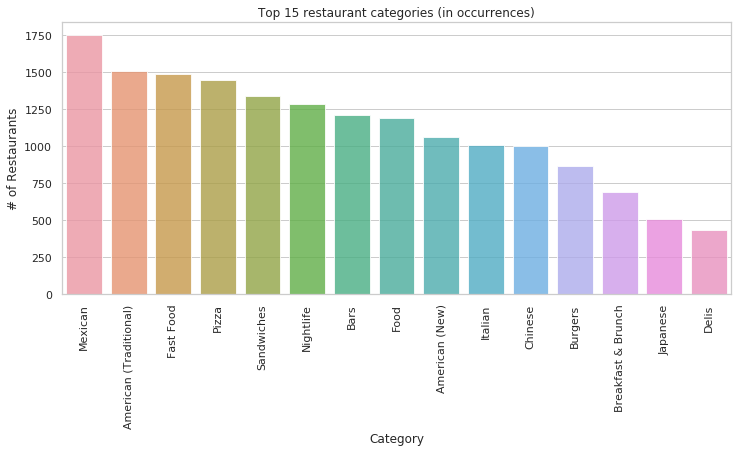

In [0]:
plot_value_counts(category_count[:15,], title = 'Top 15 restaurant categories (in occurrences)', 
                  x_label = 'Category' , y_label = '# of Restaurants', rotation = 90)

In [0]:
df = df_reviews.merge(df_bus, on = 'business_id')

In [0]:
print(len(df_reviews), 'total reviews')
print(len(df), 'restaurant reviews')
df.head()

1125458 total reviews
706646 restaurant reviews


,votes,user_id,stars_x,date,text,type_x,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars_y,latitude,attributes,type_y
0,"{'funny': 0, 'useful': 1, 'cool': 0}",zvNimI98mrmhgNOOrzOiGg,4,2008-07-07,Pretty good dinner with a nice selection of fo...,review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
1,"{'funny': 0, 'useful': 0, 'cool': 0}",p4ySEi8PEli0auZGBsy6gA,4,2009-05-03,Good truck stop dining at the right price. We ...,review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
2,"{'funny': 6, 'useful': 0, 'cool': 0}",ZYaumz29bl9qHpu-KVtMGA,4,2009-05-04,"If you like lot lizards, you'll love the Pine ...",review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
3,"{'funny': 0, 'useful': 0, 'cool': 0}",SvS7NXWG2B2kFoaHaWdGfg,4,2010-10-30,Enjoyable experience for the whole family. The...,review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
4,"{'funny': 0, 'useful': 0, 'cool': 0}",qOYI9O0ecMJ9VaqcM9phNw,4,2011-02-06,One of my favorite truck stop diners with soli...,review,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business


In [0]:
def preprocess(text):
    # Remove accents
    text = unidecode(text)
    # Remove line breaks and tab
    text = re.sub(r'[\t\n\r]', '', text)
    # Remove http links
    text = re.sub(r'http\S+', '', text)
    # Convert to lowercase
    text = text.lower().strip()
    return text

In [0]:
df.text = df.text.apply(lambda x : preprocess(x))

In [0]:
%%time
reviews_category_count = df.categories.apply(pd.Series).stack().value_counts()

CPU times: user 2min 43s, sys: 3.46 s, total: 2min 46s
Wall time: 2min 44s


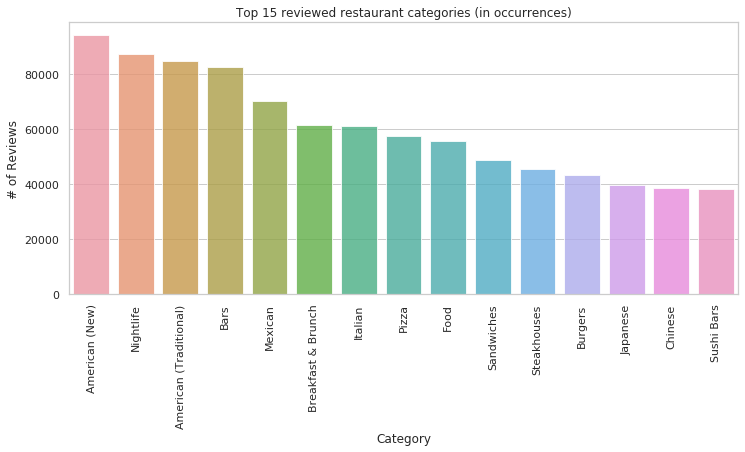

In [0]:
plot_value_counts(reviews_category_count[:15,], title = 'Top 15 reviewed restaurant categories (in occurrences)', 
                  x_label = 'Category' , y_label = '# of Reviews', rotation = 90)

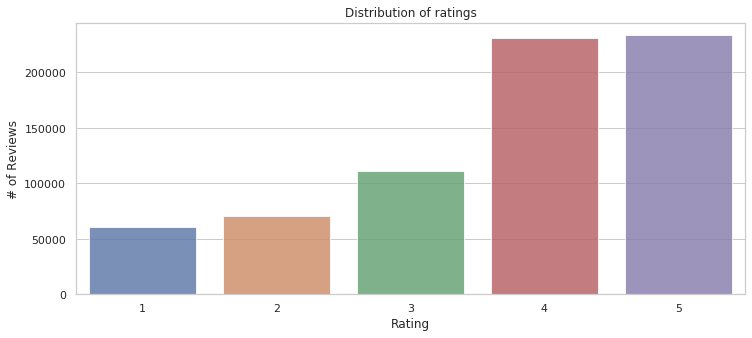

In [0]:
plot_value_counts(df.stars_x.value_counts(), title = 'Distribution of ratings', 
                  x_label = 'Rating' , y_label = '# of Reviews')

### Task 1.1
Use a topic model (e.g., PLSA or LDA) to extract topics from all the review text (or a large sample of them) and visualize the topics to understand what people have talked about in these reviews.

In [0]:
def vectorize(text_list, max_features=20000):
    print(f"Vectorizing {len(text_list)} documents using {max_features} max_features")
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=max_features,
                             min_df=2, stop_words='english',
                             use_idf=True,
                             token_pattern='[a-zA-Z0-9]{3,}')
    
    return vectorizer, vectorizer.fit_transform(text_list)

def create_lda_model(matrix, n_components = 10):
    print(f"Creating LDA model with {n_components} components")
    lda_model = LatentDirichletAllocation(n_components=n_components,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=42,          # Random state
                                      batch_size=512,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                         )
    lda_model.fit(matrix)
    return lda_model

In [0]:
%%time
#vectorizer, matrix = vectorize(df.text.sample(n = 300000, random_state = 42), max_features = 20000)
vectorizer, matrix = vectorize(df.text, max_features = 20000)

Vectorizing 706646 documents using 20000 max_features
CPU times: user 46.7 s, sys: 51 ms, total: 46.8 s
Wall time: 46.9 s


In [0]:
%%time
lda_model = create_lda_model(matrix, n_components = 10)

In [0]:
dump(lda_model, 'lda_model_20k-features-700k-reviews.joblib')

In [0]:
lda_model = load('lda_model_20k-features-700k-reviews.joblib')

In [21]:
%%time
panel = pyLDAvis.sklearn.prepare(lda_model, matrix, vectorizer, mds='tsne')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 3min 33s, sys: 3.53 s, total: 3min 37s
Wall time: 24min 50s


In [22]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9      367.895935  100.828110       1        1  40.027639
7     -342.273590  -19.101385       2        1  17.202311
3      -46.297852  396.061829       3        1  12.538247
4     -200.942551  193.226105       4        1   7.845909
5      226.769745 -111.701073       5        1   5.740151
8       80.699867  135.933121       6        1   4.598498
6       71.868835 -314.410370       7        1   4.023258
1     -207.032242 -267.466522       8        1   3.028034
2      232.584213  349.177368       9        1   2.904627
0      -54.959965  -54.355915      10        1   2.091326, topic_info=      Category          Freq     Term         Total  loglift  logprob
13243  Default  16352.000000    pizza  16352.000000  30.0000  30.0000
17420  Default   9077.000000    sushi   9077.000000  29.0000  29.0000
7959   Default  24046.000000    great  24046.000000  28.0000  28.0000
17569  Default   7263.000000    tacos   7263.000000  27.0000  27.0000
15679  Default  17778.000000  service  17778.000000  26.0000  26.0000
...        ...           ...      ...           ...      ...      ...
19769  Topic10    523.971840     wrap   1309.923169   2.9511  -5.0750
10062  Topic10    417.938920    latte    676.489382   3.3858  -5.3012
9994   Topic10    547.230602     lamb   1874.544506   2.6361  -5.0316
12342  Topic10    511.693359  options   3252.517698   2.0179  -5.0988
15190  Topic10    405.448355    salad   7937.557784   0.8930  -5.3315

[802 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
121        1  0.992403         2013
255        6  0.978819          7am
283        6  0.978096        aaron
334       10  0.996248         acai
410        1  0.990940  acknowledge
...      ...       ...          ...
19893      3  0.130485         york
19893      4  0.064349         york
19893      9  0.504958         york
19911      8  0.992052          yrs
19981      9  0.993170         ziti

[2156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 4, 5, 6, 9, 7, 2, 3, 1])

In [0]:
def extract_topic_words(lda_model, vectorizer, n_top_words = 30):
  topic_words = {}
  vocab = vectorizer.get_feature_names()

  for topic, comp in enumerate(lda_model.components_):
      word_idx = np.argsort(comp)[::-1][:n_top_words]

      # store the words most relevant to the topic
      topic_words[topic] = {vocab[i]: comp[i] for i in word_idx}
  return topic_words

Topic: 0


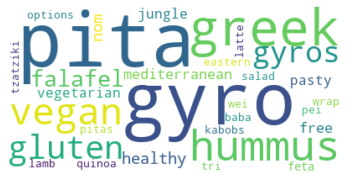

Topic: 1


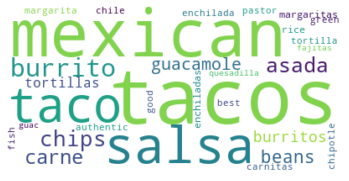

Topic: 2


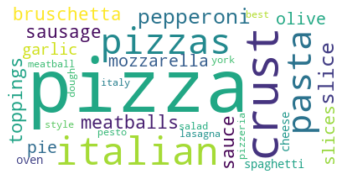

Topic: 3


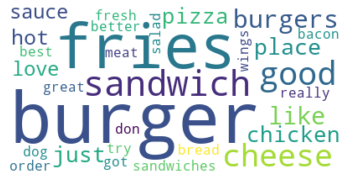

Topic: 4


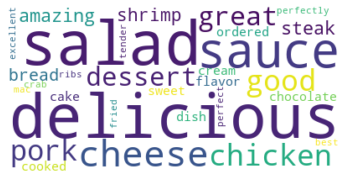

Topic: 5


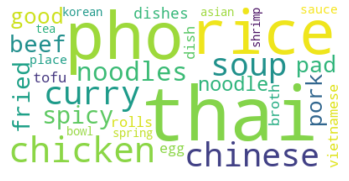

Topic: 6


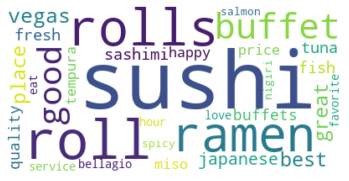

Topic: 7


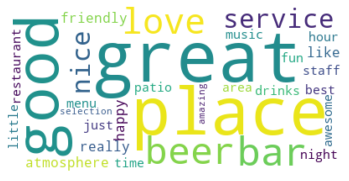

Topic: 8


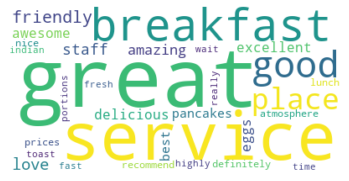

Topic: 9


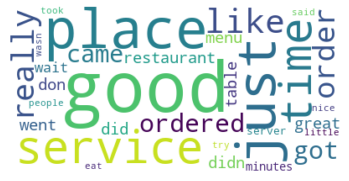

In [20]:
topic_words = extract_topic_words(lda_model, vectorizer)

for topic, freq_dict in topic_words.items():
    print('Topic: %d' % topic)
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Task 1.2

Do the same for two subsets of reviews that are interesting to compare (e.g., positive vs. negative reviews for a particular cuisine or restaurant), and visually compare the topics extracted from the two subsets to help understand the similarity and differences between these topics extracted from the two subsets. You can form these two subsets in any way that you think is interesting.

In [0]:
df_italian = df[df.categories.apply(lambda x : 'Italian' in x)]

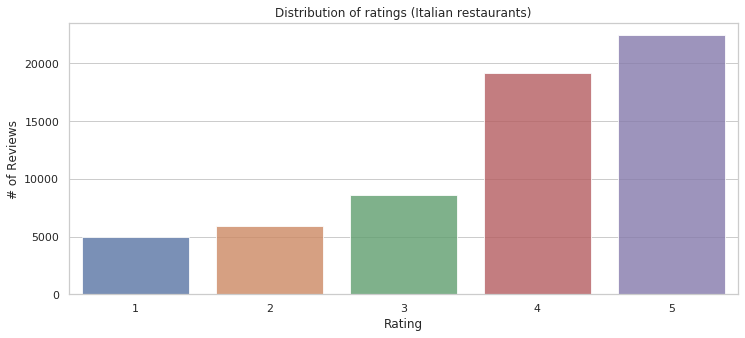

In [0]:
plot_value_counts(df_italian.stars_x.value_counts(), title = 'Distribution of ratings (Italian restaurants)', 
                  x_label = 'Rating' , y_label = '# of Reviews')


In [0]:
df_italian_negative = df_italian[df_italian.stars_x == 1]
df_italian_positive = df_italian[df_italian.stars_x == 5]

In [0]:
print(len(df_italian_negative))
print(len(df_italian_positive))

4979
22402


In [0]:
%%time
vectorizer_negative, matrix_negative = vectorize(df_italian_negative.text, max_features = 30000)
vectorizer_positive, matrix_positive = vectorize(df_italian_positive.text, max_features = 30000)

Vectorizing 4979 documents using 30000 max_features
Vectorizing 22402 documents using 30000 max_features
CPU times: user 1.82 s, sys: 28 ms, total: 1.85 s
Wall time: 1.86 s


In [0]:
%%time
lda_model_negative = create_lda_model(matrix_negative, n_components = 5)
lda_model_positive = create_lda_model(matrix_positive, n_components = 5)

Creating LDA model with 5 components
Creating LDA model with 5 components
CPU times: user 9.91 s, sys: 1.64 s, total: 11.5 s
Wall time: 43.7 s


In [0]:
pyLDAvis.sklearn.prepare(lda_model_negative, matrix_negative, vectorizer_negative, mds='tsne')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2       12.909284 -198.852356       1        1  88.904534
0      -40.401997   84.997383       2        1   2.781726
1      108.056335    6.580519       3        1   2.773065
3     -102.226730  -77.321419       4        1   2.770631
4      178.334534 -145.899750       5        1   2.770044, topic_info=     Category       Freq     Term      Total  loglift  logprob
9337  Default  10.000000     word  10.000000  30.0000  30.0000
7617  Default   8.000000     skip   8.000000  29.0000  29.0000
5630  Default  10.000000   number  10.000000  28.0000  28.0000
1491  Default   9.000000    chain   9.000000  27.0000  27.0000
5901  Default   9.000000      par   9.000000  26.0000  26.0000
...       ...        ...      ...        ...      ...      ...
580    Topic5   0.090208    asked  68.366874  -3.0442  -9.1404
8576   Topic5   0.090164     told  66.553276  -3.0178  -9.1409
134    Topic5   0.090116      9pm   3.948039  -0.1936  -9.1414
5036   Topic5   0.090090     make  46.676583  -2.6639  -9.1417
4525   Topic5   0.090088  italian  64.584963  -2.9886  -9.1417

[323 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3         1  0.922928       100
21        1  0.838200       115
134       1  1.013161       9pm
275       1  0.862537  affected
403       1  0.717095       amy
...     ...       ...       ...
9355      1  0.991757     worth
9396      1  0.956799      year
9415      1  0.988839     yikes
9428      1  0.938546      yuck
9430      1  1.024160       yuk

[122 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])

In [0]:
pyLDAvis.sklearn.prepare(lda_model_positive, matrix_positive, vectorizer_positive, mds='tsne')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1       12.909284 -198.852356       1        1  87.468301
2      -40.401997   84.997383       2        1   3.231576
0      108.056335    6.580519       3        1   3.135863
3     -102.226730  -77.321419       4        1   3.083124
4      178.334534 -145.899750       5        1   3.081136, topic_info=      Category        Freq        Term       Total  loglift  logprob
11279  Default  946.000000       pizza  946.000000  30.0000  30.0000
6925   Default  882.000000       great  882.000000  29.0000  29.0000
11049  Default   18.000000      period   18.000000  28.0000  28.0000
6147   Default  760.000000        food  760.000000  27.0000  27.0000
5065   Default   12.000000       eddie   12.000000  26.0000  26.0000
...        ...         ...         ...         ...      ...      ...
12653   Topic5    1.318440  richardson    2.137654   2.9966  -7.9619
14540   Topic5    1.307011    stranded    2.128670   2.9921  -7.9706
8310    Topic5    1.313939       kebab    2.143457   2.9905  -7.9654
8276    Topic5    1.313937       kafta    2.143456   2.9905  -7.9654
1566    Topic5    1.286002      belini    2.126936   2.9767  -7.9868

[182 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
189        2  0.898108        45min
623        4  0.461720       alisha
694        2  0.832499        amaze
700        1  0.998587      amazing
767        3  0.700088       andrew
...      ...       ...          ...
16366      5  0.450303         walt
16614      1  0.997517         wine
16841      5  0.775467  yumalicious
16876      3  0.604404         zany
16914      2  0.825033         zoyo

[160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4, 5])

Topic: 0


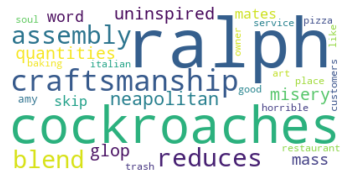

Topic: 1


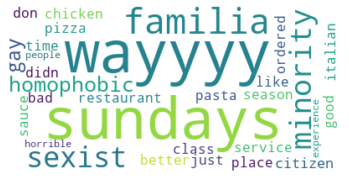

Topic: 2


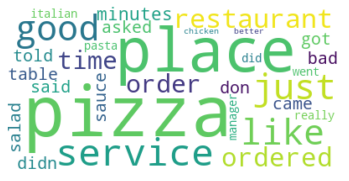

Topic: 3


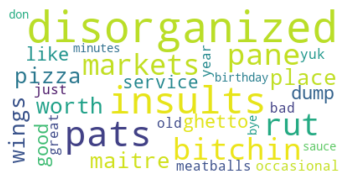

Topic: 4


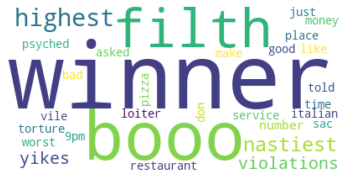

In [0]:
topic_words_negative = extract_topic_words(lda_model_negative, vectorizer_negative)

for topic, freq_dict in topic_words_negative.items():
    print('Topic: %d' % topic)
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Topic: 0


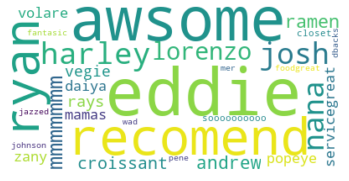

Topic: 1


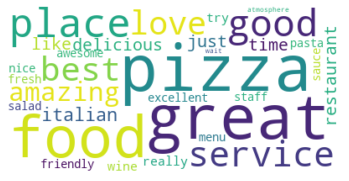

Topic: 2


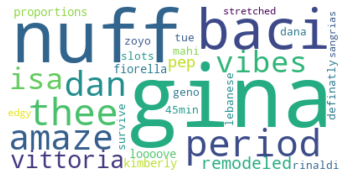

Topic: 3


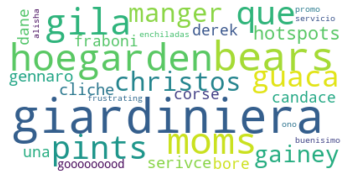

Topic: 4


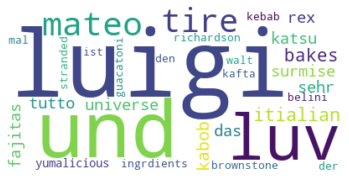

In [0]:
topic_words_positive = extract_topic_words(lda_model_positive, vectorizer_positive)

for topic, freq_dict in topic_words_positive.items():
    print('Topic: %d' % topic)
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()